- Tommaso BARBERIS p1708628
- Bertrand HUGUENIN-BIZOT p2019360

# TP Clustering de time-series

Veuillez trouver dans ce _notebook_ jupyter nos lignes de codes permettant de faire le clustering sur de données de type __time-series__. Pour faire cela on utilisera deux approche différents qu'on comparera par la suite: <br/>
- clustering de type "hierarchique"
- autre type de clustering, de notre choix

Pour les deux méthodes, on s'appuyera sur deux types de distances, la distance __euclidienne__ et la distance dite __Dynamic Time Warping__ (__DTW__). Pour évaluer les deux clustering, on calculera le score de __Rand__.

### Dynamic Time Warping
Dynamic Time Warping (DTW) est un moyen de comparer deux séquences - généralement temporelles - qui ne se synchronisent pas parfaitement. C'est une méthode pour calculer la correspondance optimale entre deux séquences. DTW est utile dans de nombreux domaines tels que la reconnaissance vocale, l'exploration de données, les marchés financiers, la bio-informatique etc. Il est couramment utilisé dans l'exploration de données pour mesurer la distance entre deux séries chronologiques.


### Indice de Rand
Il s'agit d'une mesure utilisée en dans le clustering de données qui permet la comparaison de deux partitionnements.

#### Définition
Donné un ensemble de $n$ éléments $S = {o_1, ..., o_n}$ et deux partitionnements de $S$ à comparer, $X = {X_1, ..., X_r}$ un partitionnement de $S$ en $r$ sous-ensembles, et $Y = {Y_1, .., Y_s}$ un partitionnement de $S$ en $s$ sous-ensembles, on peut définir: <br/>
- $a$, le nombre de paires d'éléments en $S$ qui sont dans le même sous-ensemble de $X$ et de $Y$;
- $b$, le nombre de paires d'éléments en $S$ qui sont dans sous-ensembles différents de $X$ et de $Y$;
- $c$, le nombre de paires d'éléments en $S$ qui sont dans le même sous-ensemble de $X$ mais en sous-ensemble différents de $Y$;
- $d$, le nombre de paires d'éléments en $S$ qui sont dans sous-ensembles différents de $X$ mais dans le même sous-ensemble de $Y$.

L'indice de Rand est donc calculé ainsi: <br/><br/>
<center>$R = \frac{a + b}{a + b + c + d} = \frac{a + b}{n \choose k}$</center>

<br/>
Pour pouvoir les deux types de distance et de clustering, on utilisera l'index de __Rand ajustée__ (la formule mathématique ne sera pas montré ici), qui permet de corriger le fait de regrouper certains éléments uniquement par chance.

<br/><br/>
source: [Objective Criteria for the Evaluation of Clustering Methods](https://doi.org/10.2307%2F2284239)

In [1]:
# import of libraries

from scipy.cluster.hierarchy import complete, fcluster, dendrogram, linkage
from sklearn.metrics.cluster import adjusted_rand_score
from dtaidistance import clustering, dtw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Plane_TRAIN", sep=",", header=None)

group=np.array(list(data.iloc[0:,0]))
data = data.iloc[0:,1:]
time_series = np.array(data)
num_group = len(set(group))

## 1. Clustering hiérarchique

### 1.1 Avec distance euclidienne

#### Representation graphique:

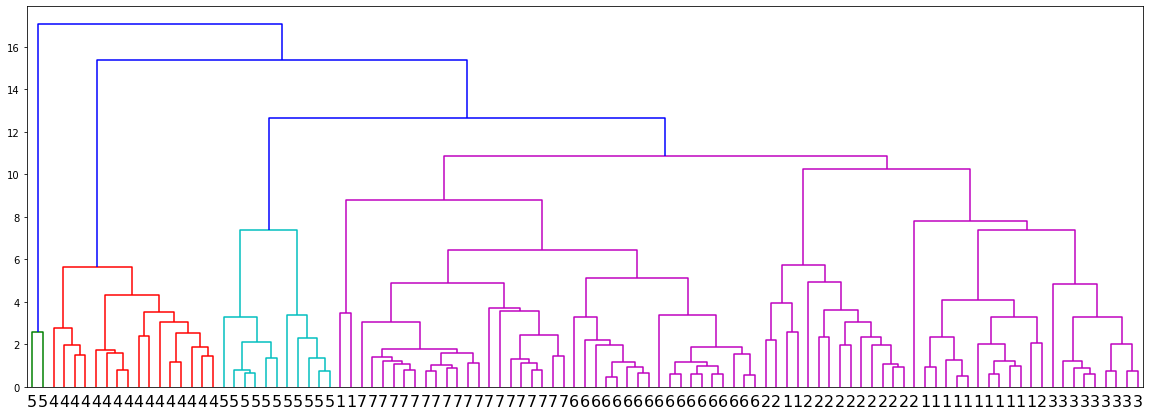

In [4]:
linked_eucl = linkage(time_series, method='complete', metric='euclidean')

plt.figure(figsize=(20, 7))


dendrogram(linked_eucl,
            orientation='top',
            labels=list(group),
            distance_sort='descending',
            show_leaf_counts=True
          )
plt.tick_params(axis='x', labelsize=16)
plt.xticks(rotation=0)

plt.show()

#### Calcul du score de Rand pour estimer la correspondance entre les clusters créés et les classes initiales:

In [5]:
clust_eucl = list(fcluster(linked_eucl, num_group, criterion='maxclust')) # assignation des séries temporelles aux 7 clusters correspondant aux 7 classes

adjusted_rand_score(clust_eucl, group)

0.6225499730650536

### 1.2 Avec distance DTW

#### Representation graphique:

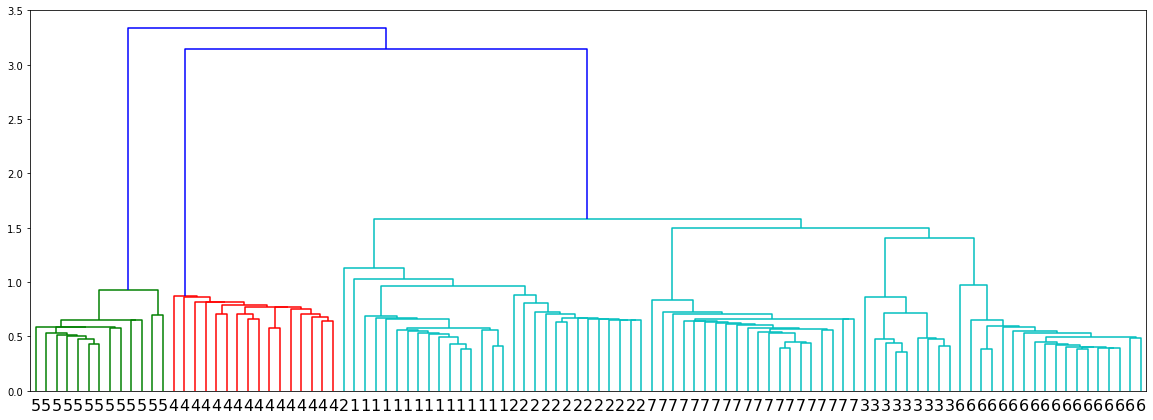

In [6]:
distance = dtw.distance_matrix_fast(time_series, use_mp=True)

from scipy.spatial.distance import squareform

condensed_dist = squareform(distance)
linked_dtw = linkage(condensed_dist)

plt.figure(figsize=(20, 7))


dendrogram(linked_dtw,
            orientation='top',
            labels=list(group),
            distance_sort='descending',
            show_leaf_counts=True
          )
plt.tick_params(axis='x', labelsize=16)
plt.xticks(rotation=0)

plt.show()

#### Calcul du score de Rand pour estimer la correspondance entre les clusters créés et les classes initiales:

In [7]:
clust_dtw = list(fcluster(linked_dtw, num_group, criterion='maxclust')) # assignation des séries temporelles aux 7 clusters correspondant aux 7 classes

adjusted_rand_score(clust_dtw, group)

0.8572988458807934

En comparant les deux métriques pour le clustering hierarchique, on peut rapidement s'apercevoir que la métrique __DTW__ offre un clustering bien meilleure qu'avec la distance __euclidienne__.
On peut le voir graphiquement, les séries témporelles correspondant à une même classe sont quasiment toutes réunies dans le même cluster pour __DTW__ (exception d'une série appartenant à la classe __2__) alors que dans l'autre dendogramme on retrouve des séries disjointes des autres série de même classe (séries des classes __5__, __1__ et __2__). <br/>
Par ailleurs, cela se confirme avec le score de l'index de __Rand__, lequel a une valeur de __0.86__ pour le __DTW__ et d'uniquement __0.62__ pour la distance __euclidienne__.

## 2. Clustering avec k-means

In [18]:
def kmean_plot(model, label, num_group, time_series, title):
    """
    Fonction qui permet de répresenter les séries temporelles regroupées par cluster.
    """
    
    plt.figure(figsize=(20,20))

    for clust in range(num_group):

        plt.subplot(3, 3, clust + 1)    
       
        for serie in time_series[label == clust+1]:
            plt.plot(serie.ravel(), "k-", alpha=.2)
        
        if model != "null":
            plt.plot(model.cluster_centers_[clust].ravel(), "r-")
        plt.xlim(0, time_series.shape[1])
        plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (clust + 1),
                 transform=plt.gca().transAxes)
        if clust == 1:
            plt.title(title)

#### Representation des séries témporelles en fonction de la classe d'origine (permettra l'évaluation du clustering):

In [19]:
kmean_plot(model="null", group=group, num_group=num_groupup, time_series=times, "Classe d'origine")

SyntaxError: positional argument follows keyword argument (<ipython-input-19-f0d02fba1f1e>, line 1)

### 2.1 Avec distance euclidienne

In [11]:
from tslearn.clustering import TimeSeriesKMeans

model_eucl = TimeSeriesKMeans(n_clusters=num_group, metric="euclidean")
label_eucl = model_eucl.fit_predict(time_series) + 1

#### Representation graphique:

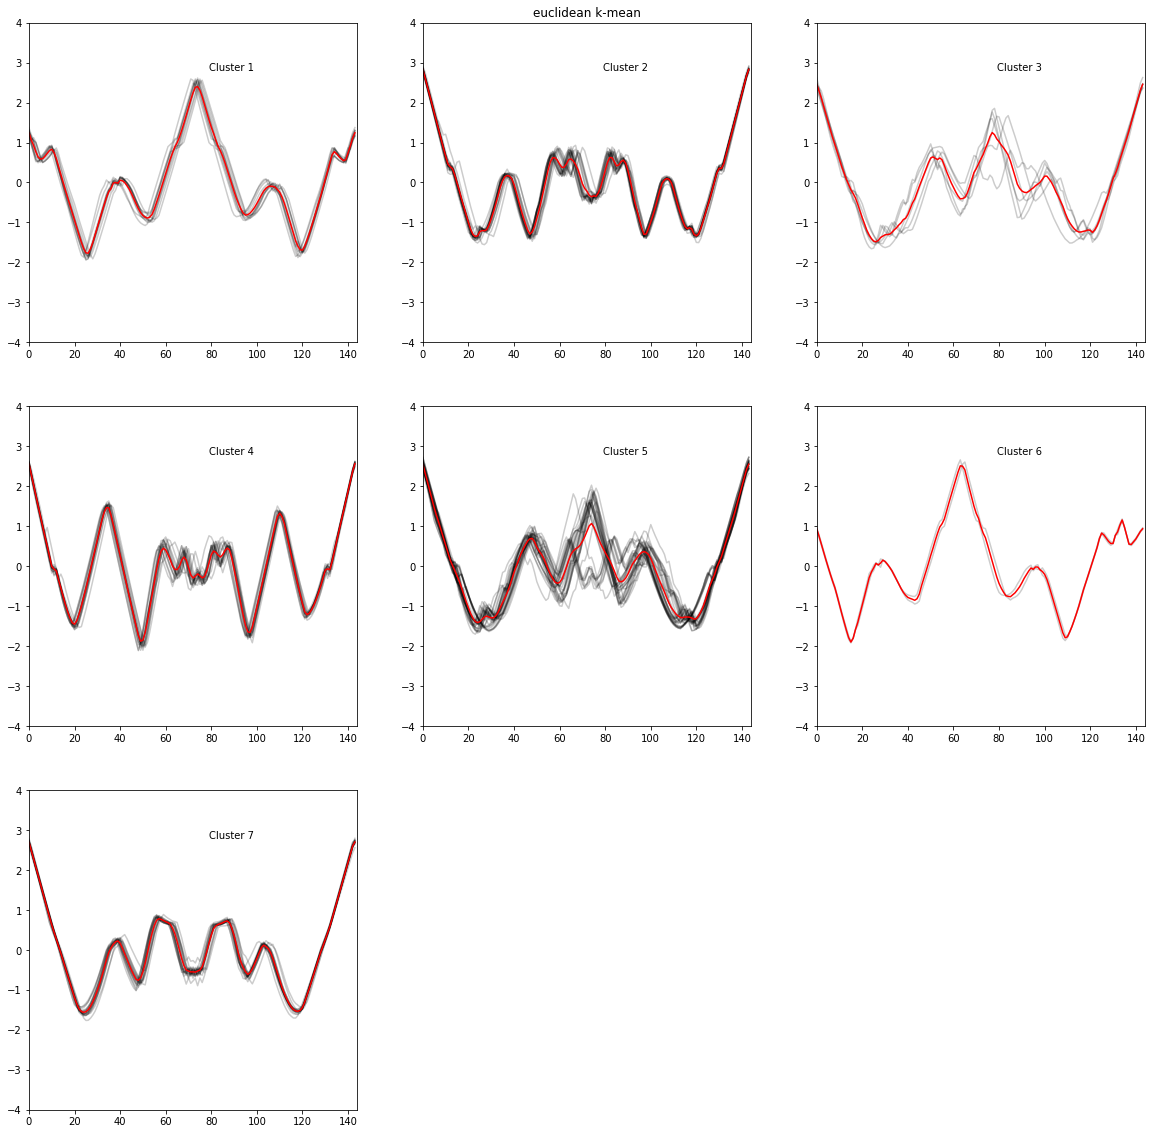

In [12]:
kmean_plot(model_eucl, label_eucl, num_group, time_series, "euclidean k-mean")

#### Calcul du score de Rand:

In [13]:
adjusted_rand_score(label_eucl, group)

0.7108555501696558

### 2.2 Avec distance DTW

In [14]:
model_dtw = TimeSeriesKMeans(n_clusters=num_group, metric="dtw")
label_dtw = model_dtw.fit_predict(time_series)

TypeError: expected dtype object, got 'numpy.dtype[float64]'

#### Representation graphique:

In [ ]:
kmean_plot(model_dtw, label_dtw, num_group, time_series, "DTW k-mean")

#### Calcul du score de Rand:

In [ ]:
adjusted_rand_score(label_dtw, group)